# Processing workflow for Chlorophyll-a fluorescence and particulate backscatter

## Chlorophyll-a Processing Module for Ocean Glider Data

1) Dark Value Calculation and correction
2) Quenchinhg correction
3) Potential correction to define Chla from fluorescence

## Dark calculation

In [2]:
from pathlib import Path
import os
import xarray as xr
#import variables.chla_fluorescence as chla
import numpy as np
import matplotlib.pyplot as plt

# Define paths
path = Path(os.getcwd())
scripts = path.parent.absolute()
project = scripts.parent.absolute()
data = os.path.join(project, 'Data')

# Load your glider data
ds = xr.open_dataset(os.path.join(data, 'Gliders/NRT/Doombar_648_Profiled.nc'))

In [3]:
def compute_dark_value(ds, depth_threshold=200, n_profiles=5, config_path=None):
    """
    Compute dark value for chlorophyll-a correction.
    
    The dark value represents the sensor's baseline reading in the absence of
    chlorophyll fluorescence. Computed as the median of minimum CHLA values from
    deep profiles (>= depth_threshold).
    
    Parameters
    ----------
    ds : xarray.Dataset
        Glider dataset with variables: CHLA, DEPTH (or PRES), PROFILE_NUMBER
    depth_threshold : float, optional
        Minimum depth [m] for dark value calculation (default: 200)
    n_profiles : int, optional
        Number of deep profiles to use (default: 5)
    config_path : str or Path, optional
        Path to config file to check for existing dark value
        
    Returns
    -------
    dark_value : float
        Computed dark value
    profile_data : dict
        Dictionary containing profile information used in calculation
        Keys are profile numbers, values are dicts with 'depth', 'chla', 'min_value', 'min_depth'
    """
    
    # Check config file for existing dark value
    if config_path is not None:
        dark_value = load_dark_value_from_config(config_path)
        if dark_value is not None:
            print(f"Using dark value from config: {dark_value:.6f}")
            return dark_value, {}
    
    print(f"Computing dark value from profiles reaching >= {depth_threshold}m")
    
    # Get required variables
    prof_idx = ds.PROFILE_NUMBER.values
    unique_prof = np.unique(prof_idx[~np.isnan(prof_idx)])
    unique_prof = unique_prof[1: len(unique_prof)]  # Exclude first profile
    # Get depth variable
    if "DEPTH" in ds.variables:
        depth = abs(ds.DEPTH.values)
    elif "PRES" in ds.variables:
        depth = ds.PRES.values
        print("Using PRES as depth proxy")
    else:
        raise ValueError("No DEPTH or PRES variable found in dataset")
    
    chla = ds.CHLA.values
    
    # Find first n_profiles reaching depth_threshold
    deep_profiles = []
    for prof in unique_prof:
        if len(deep_profiles) >= n_profiles:
            break
        
        prof_mask = prof_idx == prof
        prof_depth = depth[prof_mask]
        
        if np.nanmax(prof_depth) >= depth_threshold:

            prof_chla = chla[prof_mask]

            # Remove NaN values
            valid_mask = np.isfinite(prof_depth) & np.isfinite(prof_chla)
            prof_depth = prof_depth[valid_mask]
            prof_chla = prof_chla[valid_mask]
        
            if len(prof_depth) > 200:#Make sure the profile has enough data points
                deep_profiles.append(prof)
            
    if len(deep_profiles) == 0:
        print(f"WARNING: No profiles reaching {depth_threshold}m found.")
        print(f"Using deepest data from first {n_profiles} profiles instead.")
        deep_profiles = unique_prof[:n_profiles]
    elif len(deep_profiles) < n_profiles:
        print(f"WARNING: Only found {len(deep_profiles)} profiles reaching {depth_threshold}m")
    
    print(f"Using {len(deep_profiles)} profiles: {deep_profiles}")
    
    # Compute minimum CHLA for each deep profile
    min_values = []
    profile_data = {}
    
    for prof in deep_profiles:
        prof_mask = prof_idx == prof
        prof_depth = depth[prof_mask]
        prof_chla = chla[prof_mask]
        
        # Remove NaN values
        valid_mask = np.isfinite(prof_depth) & np.isfinite(prof_chla)
        prof_depth = prof_depth[valid_mask]
        prof_chla = prof_chla[valid_mask]
        
        if len(prof_depth) == 0:
            print(f"WARNING: Profile {prof} has no valid data, skipping")
            continue
        
        # Get data from depth_threshold and deeper
        deep_mask = prof_depth >= depth_threshold
        
        if np.sum(deep_mask) > 0:
            deep_chla = prof_chla[deep_mask]
            deep_depth = prof_depth[deep_mask]
            min_idx = np.nanargmin(deep_chla)
            min_val = deep_chla[min_idx]
            min_depth = deep_depth[min_idx]
        else:
            # Fallback: use deepest 10% of profile
            n_deep = max(int(0.1 * len(prof_chla)), 1)
            sorted_indices = np.argsort(prof_depth)[-n_deep:]
            deep_portion = prof_chla[sorted_indices]
            min_idx = np.nanargmin(deep_portion)
            min_val = deep_portion[min_idx]
            min_depth = prof_depth[sorted_indices[min_idx]]
            print(f"Profile {prof}: Using deepest data (max depth: {np.max(prof_depth):.1f}m)")
        
        if np.isfinite(min_val):
            min_values.append(min_val)
            profile_data[int(prof)] = {
                'depth': prof_depth,
                'chla': prof_chla,
                'min_value': min_val,
                'min_depth': min_depth
            }
            print(f"Profile {prof}: min CHLA = {min_val:.4f} at {min_depth:.1f}m")
    
    if len(min_values) == 0:
        raise ValueError("Could not compute dark value: no valid CHLA data in deep profiles")
    
    # Compute median of minimum values
    dark_value = np.nanmedian(min_values)
    print(f"\nComputed dark value: {dark_value:.6f} (median of {len(min_values)} profile minimums)")
    print(f"Min values range: {np.min(min_values):.6f} to {np.max(min_values):.6f}")
    
    # Save to config if path provided
    if config_path is not None:
        save_dark_value_to_config(dark_value, config_path)
    
    return dark_value, profile_data


In [4]:
dark_value, profiles = compute_dark_value(ds, depth_threshold=200, n_profiles=5)


Computing dark value from profiles reaching >= 200m
Using 5 profiles: [np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(24.0)]
Profile 8.0: min CHLA = -0.0994 at 277.9m
Profile 9.0: min CHLA = -0.1065 at 318.6m
Profile 10.0: min CHLA = -0.0994 at 338.0m
Profile 11.0: min CHLA = -0.0994 at 631.6m
Profile 24.0: min CHLA = -0.1065 at 733.0m

Computed dark value: -0.099400 (median of 5 profile minimums)
Min values range: -0.106500 to -0.099400


## Plot dark profiles

In [5]:
def plot_dark_profiles(ds, profile_data, dark_value, depth_threshold=200, 
                       figsize=(10, 8), save_path=None):
    """
    Plot the profiles used to compute the dark value.
    
    Shows depth vs CHLA with minimum values highlighted.
    
    Parameters
    ----------
    ds : xarray.Dataset
        Glider dataset (not directly used, info from profile_data)
    profile_data : dict
        Dictionary from compute_dark_value() containing profile information
    dark_value : float
        Computed dark value
    depth_threshold : float, optional
        Depth threshold used in calculation (default: 200)
    figsize : tuple, optional
        Figure size (default: (10, 8))
    save_path : str or Path, optional
        If provided, save figure to this path
        
    Returns
    -------
    fig, ax : matplotlib figure and axis objects
    """
    
    if len(profile_data) == 0:
        print("No profile data available for plotting")
        return None, None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(profile_data)))
    
    for idx, (prof, data) in enumerate(profile_data.items()):
        depth = data['depth']
        chla = data['chla']
        min_val = data['min_value']
        min_depth = data['min_depth']
        
        # Plot profile
        ax.plot(
            chla,
            -depth,
            color=colors[idx],
            linewidth=2,
            label=f"Profile {prof}: min={min_val:.4f}",
            alpha=0.7
        )
        
        # Highlight minimum value using stored min_depth
        ax.plot(
            min_val,
            -min_depth,
            'o',
            color=colors[idx],
            markersize=10,
            markeredgecolor='black',
            markeredgewidth=1.5,
            zorder=5
        )
    
    # Add dark value line
    ax.axvline(
        dark_value,
        color='red',
        linestyle='--',
        linewidth=2.5,
        label=f'Dark Value: {dark_value:.4f}',
        zorder=3
    )
    
    # Add depth threshold reference line
    ax.axhline(-depth_threshold, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    ax.text(ax.get_xlim()[1] * 0.95, -depth_threshold, f'{depth_threshold}m', 
            verticalalignment='bottom', horizontalalignment='right',
            fontsize=10, color='gray')
    
    ax.set_xlabel('Chlorophyll-a [mg/m³]', fontweight='bold', fontsize=12)
    ax.set_ylabel('Depth [m]', fontweight='bold', fontsize=12)
    ax.set_title('Dark Value Calculation - Deep Profiles', 
                 fontweight='bold', fontsize=14)
    ax.legend(loc='best', prop={'size': 10})
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Adjust x-axis to show detail near dark value
    all_chla = np.concatenate([data['chla'] for data in profile_data.values()])
    xmin = max(np.nanmin(all_chla), dark_value - 1)
    xmax = np.nanpercentile(all_chla, 98)
    ax.set_xlim([xmin, xmax])
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    return fig, ax


C:\Users\flapet\AppData\Local\Temp\ipykernel_17308\3042190292.py:93: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Dark Value Calculation - Deep Profiles'}, xlabel='Chlorophyll-a [mg/m³]', ylabel='Depth [m]'>)

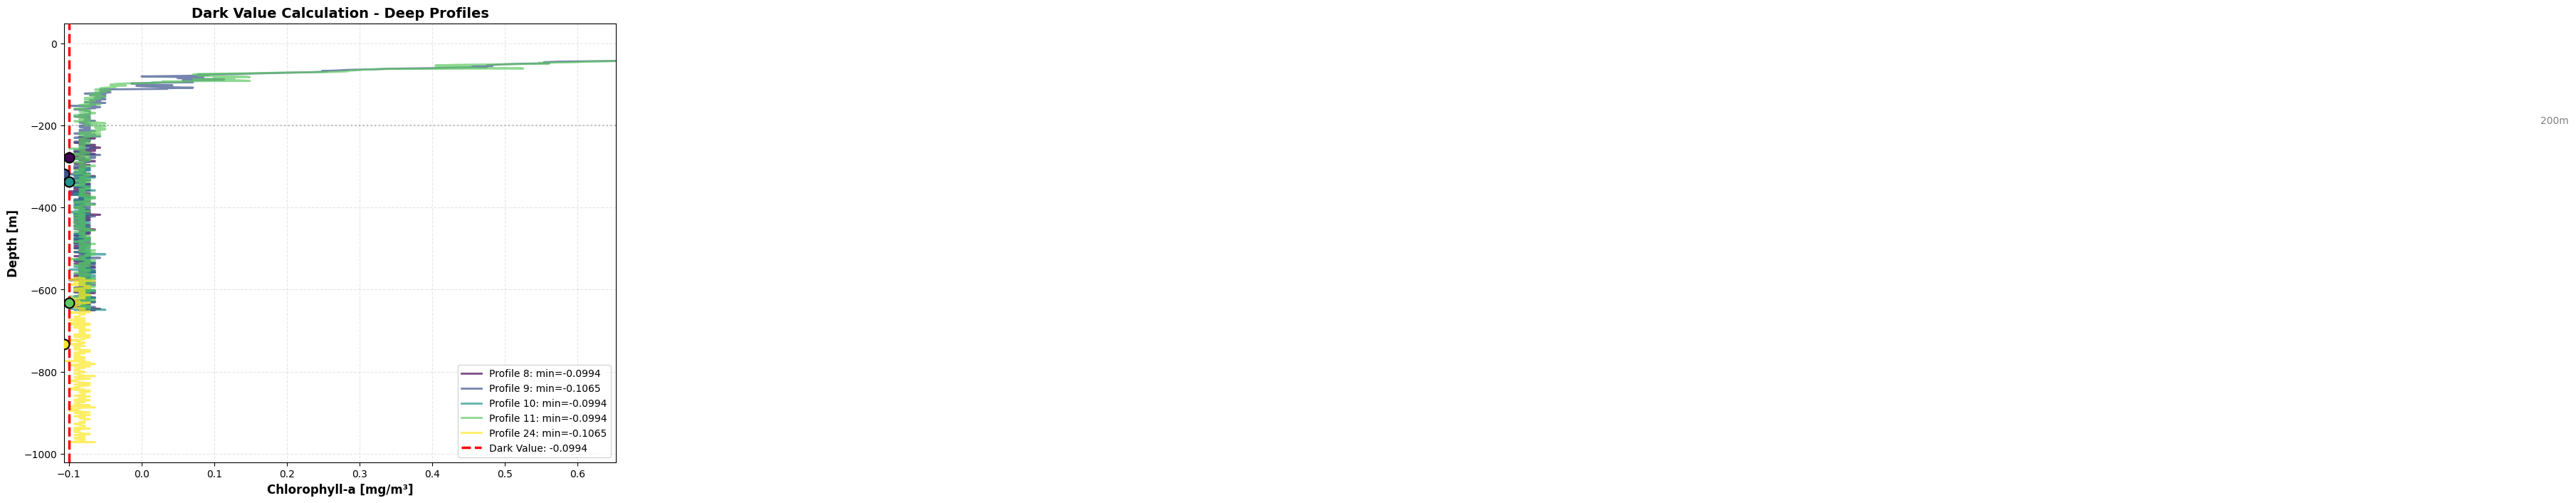

In [6]:
plot_dark_profiles(ds, profiles, dark_value, depth_threshold=200, 
                       figsize=(10, 8), save_path=None)

In [17]:
def plot_chla_transects(ds, figsize=(14, 10), save_path=None):
    """
    Plot before and after transects of CHLA correction.
    
    Shows raw CHLA, corrected CHLA_FLUORESCENCE, and their difference.
    
    Parameters
    ----------
    ds : xarray.Dataset
        Glider dataset with CHLA and CHLA_FLUORESCENCE variables
    n_profiles : int, optional
        Maximum number of profiles to display (default: 40)
        Uses middle section of deployment
    figsize : tuple, optional
        Figure size (default: (14, 10))
    save_path : str or Path, optional
        If provided, save figure to this path
        
    Returns
    -------
    fig, axes : matplotlib figure and axis objects
    """
    
    if "CHLA_FLUORESCENCE" not in ds.variables:
        raise ValueError("CHLA_FLUORESCENCE not found. Run apply_dark_correction() first.")
    
    # Select subset of data
    prof_idx = ds.PROFILE_NUMBER.values
    unique_prof = np.unique(prof_idx[~np.isnan(prof_idx)])
    unique_prof = unique_prof[1: len(unique_prof)]  # Exclude first profile
    
    n_total = len(unique_prof)
    
    # Get depth variable
    if "DEPTH" in ds.variables:
        depth = ds.DEPTH.values
    elif "PRES" in ds.variables:
        depth = -ds.PRES.values
    else:
        depth = np.zeros_like(ds.TIME.values)
    
    # Create figure with three subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=figsize, sharex=True)
    
    # Plot 1: Raw CHLA
    chla_raw = ds.CHLA.values
    vmin_raw = -0.5
    vmax_raw = np.nanpercentile(chla_raw, 95)
    
    sc1 = ax1.scatter(
        ds.TIME,
        depth,
        c=chla_raw,
        cmap='Greens',
        vmin=vmin_raw,
        vmax=vmax_raw,
        s=10
    )
    cbar1 = plt.colorbar(sc1, ax=ax1)
    cbar1.set_label('CHLA [mg/m³]', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Depth [m]', fontweight='bold', fontsize=12)
    ax1.set_title('Raw Chlorophyll-a', fontweight='bold', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Plot 2: Corrected CHLA
    chla_adj = ds.CHLA_FLUORESCENCE.values
    vmin_adj = -0.5
    vmax_adj = np.nanpercentile(chla_adj, 95)
    
    # Get dark value from attributes if available
    dark_val = ds.CHLA_FLUORESCENCE.attrs.get('dark_value', 'N/A')
    
    sc2 = ax2.scatter(
        ds.TIME,
        depth,
        c=chla_adj,
        cmap='Greens',
        vmin=vmin_adj,
        vmax=vmax_adj,
        s=10
    )
    cbar2 = plt.colorbar(sc2, ax=ax2)
    cbar2.set_label('CHLA_FLUORESCENCE [mg/m³]', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Depth [m]', fontweight='bold', fontsize=12)
    ax2.set_title(
        f'Corrected Chlorophyll-a (Dark Value: {dark_val:.4f})', 
        fontweight='bold', 
        fontsize=14
    )
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    return fig, (ax1, ax2)

## Apply the dark correction

In [7]:
def apply_dark_correction(ds, dark_value):
    """
    Apply dark value correction to CHLA data.
    
    Creates new variable CHLA_ADJ = CHLA - dark_value
    
    Parameters
    ----------
    ds : xarray.Dataset
        Glider dataset with CHLA variable
    dark_value : float
        Dark value to subtract
        
    Returns
    -------
    ds : xarray.Dataset
        Dataset with added CHLA_FLUORESCENCE variable
    """
    
    # Create adjusted chlorophyll variable
    ds["CHLA_FLUORESCENCE"] = xr.DataArray(
        ds.CHLA.values - dark_value,
        dims=ds.CHLA.dims,
        coords=ds.CHLA.coords,
    )
    
    # Copy and update attributes
    if hasattr(ds.CHLA, 'attrs'):
        ds["CHLA_FLUORESCENCE"].attrs = ds.CHLA.attrs.copy()
    ds["CHLA_FLUORESCENCE"].attrs["comment"] = (
        f"CHLA fluorescence with dark value correction (dark_value={dark_value:.6f})"
    )
    ds["CHLA_FLUORESCENCE"].attrs["dark_value"] = dark_value
    
    print(f"Applied dark value correction: CHLA_FLUORESCENCE = CHLA - {dark_value:.6f}")
    
    return ds


In [8]:
ds = apply_dark_correction(ds, dark_value)

Applied dark value correction: CHLA_FLUORESCENCE = CHLA - -0.099400


(<Figure size 1400x1000 with 4 Axes>,
 (<Axes: title={'center': 'Raw Chlorophyll-a'}, ylabel='Depth [m]'>,
  <Axes: title={'center': 'Corrected Chlorophyll-a (Dark Value: -0.0994)'}, ylabel='Depth [m]'>))

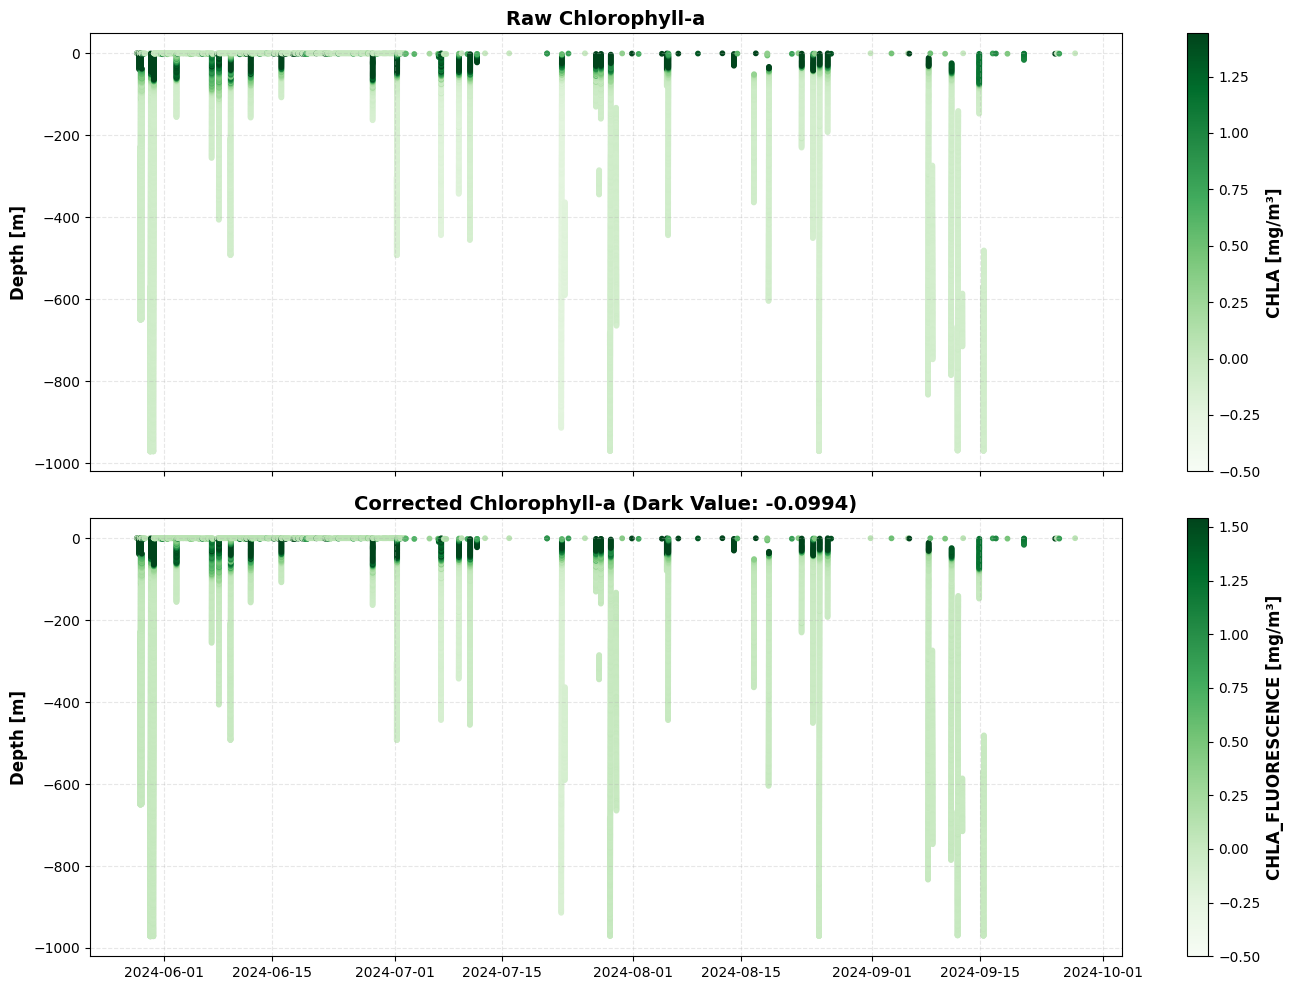

In [18]:
plot_chla_transects(ds, figsize=(14, 10), save_path=None)